In [1]:
import numpy as np

In [2]:
### Make sure the data matrix is of shape (m,d) ###
### m: number of points, d: state space dimension ###

from scipy.integrate import solve_ivp

# Define the system of ODEs
def duffing_oscillator(t, Y, delta, alpha, beta, gamma, omega):
    # If Y is just a single value, we assume the second value (y) is 0
    if np.isscalar(Y):
        x, y = Y, 0
    else:
        x, y = Y
    dxdt = y
    dydt = -delta*y - alpha*x - beta*x**3 + gamma*np.cos(omega*t)
    return [dxdt, dydt]

# Parameters
delta = 0.5
alpha = -1
beta = 1
gamma = 0
omega = 0

# Sample N=1000 initial points, with uniform distribution [-2, 2].
N = 1000
np.random.seed(39)
sample_data_x0 = (np.random.rand(N, 2) * 4) - 2
tspan = [0, 2.5]
nstep = 11
data = np.zeros((N, 2, nstep))

t_eval = np.linspace(tspan[0], tspan[1], nstep)

for idx, x0 in enumerate(sample_data_x0):
    sol = solve_ivp(duffing_oscillator, tspan, x0,
                t_eval=t_eval, args=(delta, alpha, beta, gamma, omega))
    data[idx, 0, :] = sol.y[0]
    data[idx, 1, :] = sol.y[1]

# Pairwise shifted data X and Y
X = data[:, :, :-1]  # shape: (1000, 2, 10)
Y = data[:, :, 1:]

# Transpose and reshape the data.
X = np.transpose(X, (0, 2, 1)).reshape(N * (nstep-1), 2)  # shape: (10000, 2)
Y = np.transpose(Y, (0, 2, 1)).reshape(N * (nstep-1), 2)

In [3]:
len_all = X.shape[0]
data_x_train = X[:int(0.7*len_all), :]
data_x_valid = X[int(0.7*len_all)+1:, :]

data_y_train = Y[:int(0.7*len_all), :]
data_y_valid = Y[int(0.7*len_all)+1:, :]

data_train = [data_x_train, data_y_train]
data_valid = [data_x_valid, data_y_valid]

In [21]:
from solver_resdmd import KoopmanNN, KoopmanSolver
# from solver_edmd import KoopmanNN, KoopmanSolver

basis_function = KoopmanNN(layer_sizes=[100, 100, 100], n_psi_train=97)

solver = KoopmanSolver(dic=basis_function,
                        target_dim=np.shape(data_train)[-1],
                        reg=0.1)

solver.build(data_train=data_train,
            data_valid=data_valid,
            epochs=200,
            batch_size=5000,
            lr=1e-4,
            log_interval=10,
            lr_decay_factor=.8)

Outer Epoch 1/200
Epoch 1/2
2/2 [==============================] - 1s 178ms/step - loss: 3.0265e-07 - val_loss: 2.0851e-06
Epoch 2/2
2/2 [==============================] - 0s 48ms/step - loss: 3.2664e-06 - val_loss: 2.1184e-06
Outer Epoch 2/200
Epoch 1/2
2/2 [==============================] - 0s 65ms/step - loss: 1.8324e-06 - val_loss: 1.9935e-06
Epoch 2/2
2/2 [==============================] - 0s 43ms/step - loss: 1.9245e-06 - val_loss: 3.2888e-06
Outer Epoch 3/200
Epoch 1/2
2/2 [==============================] - 0s 67ms/step - loss: 7.2708e-07 - val_loss: 1.0074e-06
Epoch 2/2
2/2 [==============================] - 0s 42ms/step - loss: 8.9627e-07 - val_loss: 1.0837e-06
Outer Epoch 4/200
Epoch 1/2
2/2 [==============================] - 0s 67ms/step - loss: 3.9163e-07 - val_loss: 6.8324e-07
Epoch 2/2
2/2 [==============================] - 0s 54ms/step - loss: 5.4168e-07 - val_loss: 5.5113e-07
Outer Epoch 5/200
Epoch 1/2
2/2 [==============================] - 0s 78ms/step - loss: 3.2951e

In [22]:
# Results from solver_edmd/solver_resdmd
evalues = solver.eigenvalues.T
efuns = solver.eigenfunctions(X)
kpm_modes = solver.compute_mode().T
N_dict = np.shape(evalues)[0]
Koopman_matrix_K = solver.K.numpy()
Psi_X = solver.get_Psi_X().numpy()
Psi_Y = solver.get_Psi_Y().numpy()
# jacobian, hessian = solver.get_derivatives(data_x_valid) # Currently the storage is not enough to calculate for larger amount of data
# np_config.enable_numpy_behavior()
outputs = {
    'efuns': efuns,
    'evalues': evalues,
    'kpm_modes': kpm_modes,
    'N_dict': N_dict,
    'Psi_X': Psi_X,
    'Psi_Y': Psi_Y,
    'K': Koopman_matrix_K,
    # "Jacobian": jacobian,  # Uncomment if needed
    # "Hessian": hessian,    # Uncomment if needed
}

In [6]:
print(type(Psi_X))
print(Psi_X.shape)

<class 'numpy.ndarray'>
(7000, 25)


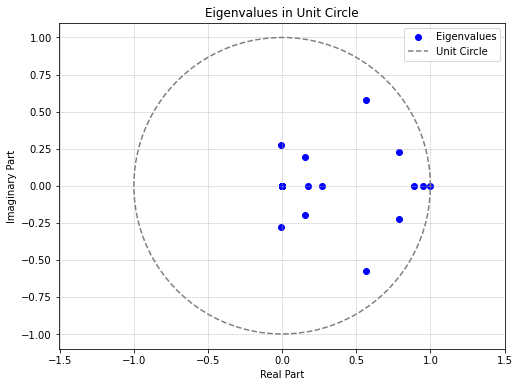

In [23]:
import matplotlib.pyplot as plt

# Assuming evalues is a numpy array of complex numbers
real_parts = evalues.real
imag_parts = evalues.imag

# Create the plot
plt.figure(figsize=(8, 6))
plt.scatter(real_parts, imag_parts, color='blue', label='Eigenvalues')

# Draw a unit circle for reference
theta = np.linspace(0, 2*np.pi, 100)
plt.plot(np.cos(theta), np.sin(theta), linestyle='--', color='grey', label='Unit Circle')

plt.title('Eigenvalues in Unit Circle')
plt.xlabel('Real Part')
plt.ylabel('Imaginary Part')
plt.axis('equal')  # Ensure the aspect ratio is equal to make the unit circle round
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()

In [17]:
print(evalues)

[ 9.99998570e-01+0.00000000e+00j  9.22778945e-01+5.03530250e-02j
  9.22778945e-01-5.03530250e-02j  7.59406029e-01+2.26927392e-01j
  7.59406029e-01-2.26927392e-01j  5.26507158e-01+6.07650040e-01j
  5.26507158e-01-6.07650040e-01j  1.33106810e-01+9.96861358e-02j
  1.33106810e-01-9.96861358e-02j  9.56471130e-02+0.00000000e+00j
  3.57164062e-02+1.19959011e-01j  3.57164062e-02-1.19959011e-01j
  2.61413665e-02+0.00000000e+00j  5.06155662e-04+1.64579062e-04j
  5.06155662e-04-1.64579062e-04j  3.52410699e-04+0.00000000e+00j
  6.90133589e-05+0.00000000e+00j  5.41101528e-05+7.66753030e-05j
  5.41101528e-05-7.66753030e-05j  6.00260560e-06+7.47133103e-06j
  6.00260560e-06-7.47133103e-06j  3.86403128e-06+0.00000000e+00j
  1.70587008e-07+0.00000000e+00j -1.34441869e-04+4.97006998e-04j
 -1.34441869e-04-4.97006998e-04j]


In [13]:
# import os
# import scipy.io as sio

# folder_path = 'data'  # Adjust the path as needed if you want a different location
# os.makedirs(folder_path, exist_ok=True)
# # Save the outputs to a .mat file named according to the number of basis functions, inside the "data" folder
# file_path = os.path.join(folder_path, f'duffing_resdmd_{N_dict}basis.mat')
# sio.savemat(file_path, outputs)
# print(f'Saved outputs for n_psi_train={50} to {file_path}')

Saved outputs for n_psi_train=50 to data\duffing_resdmd_50basis.mat
